# De Re Publica Analysis

This notebook contains some preliminary investigations of Cicero's De Re Publica.

## Part I. Read and clean in the data

First we read in the text.

In [272]:
from cltk.corpus.latin import latinlibrary
files = latinlibrary.fileids()
drp_files = [f for f in files if 'cicero/repub' in f]

drp_raw = latinlibrary.raw(drp_files)
drp_sents = latinlibrary.sents(drp_files)
drp_words = latinlibrary.words(drp_files)

print("Number of sentences:", len(drp_sents))
print("Number of words:", len(drp_words))

Number of sentences: 832
Number of words: 24885


We are going to work with the sentence data. We will clean it up to remove punctuation and non-words.

In [273]:
from cltk.stem.lemma import LemmaReplacer
lemmatizer = LemmaReplacer('latin')
from cltk.stop.latin.stops import STOPS_LIST
from string import digits
remove_digits = str.maketrans('', '', digits)
from cltk.stem.latin.j_v import JVReplacer
jv_replacer = JVReplacer()

def sentence_cleaner(sentence):
    def remove_word(word):
        if word in [".",",","-",";",":","?","&","!","(",")","lt","gt",'"']:
            return True
        if "&" in word:
            return True
        if word in STOPS_LIST +["que","ne","library","classics"]:
            return True
        if word == "":
            return True
        if len(word) == 1:
            return True
        return False
        
    def lemmatize_word(word):
        w = word.lower()
        w = w.replace("'","")
        w = w.replace('"','')
        w = w.replace(".","")
        w = jv_replacer.replace(w)
        l = lemmatizer.lemmatize(w)
        if  len(l) == 1 and (l[0] == "publica" or l[0] == "publicum"):
            return ["publica"]
        return l
    
    sent = []
    for wd in sentence:
        sent += lemmatize_word(wd)
    
    
    sent_no_nums = [wd.translate(remove_digits) for wd in sent]

    return [wd for wd in sent_no_nums if not remove_word(wd)]



sentences = [s for s in [sentence_cleaner(sent) for sent in drp_sents] if len(s) > 0]
for i in range(10):
    print("Sentence",i,":",sentences[i])
for i in range(1,10):
    print("Sentence",-i,":",sentences[-i])

Sentence 0 : ['cicero', 'reor', 'publico', 'eo']
Sentence 1 : ['tulli', 'ciceronis', 'reor', 'publico', 'libo', 'primus']
Sentence 2 : ['petu', 'liberauissent', 'duelius', 'atilius', 'metellus', 'terror', 'karthaginis', 'duo', 'scipio', 'orior', 'incendium', 'bellus', 'punici', 'secundus', 'sanguis', 'suo', 'restinguo', 'excito', 'magnus', 'copia', 'magnus', 'eneruauisset', 'marcellus', 'contundo', 'porta', 'urbs', 'auolsum', 'africanus', 'compello', 'intro', 'hostis', 'moenia']
Sentence 3 : ['verus', 'catonium', 'homo', 'ignosco', 'novo', 'omnes', 'res', 'studeo', 'quasi', 'exemplo', 'industria', 'virtus', 'duco', 'certus', 'liceo', 'tusculum', 'otium', 'delecto', 'salubris', 'propinquo', 'loco']
Sentence 4 : ['homo', 'demo', 'iste', 'puto', 'cogo', 'necessitas', 'nullus', 'unda', 'tempestas', 'summa', 'senectus', 'malo', 'jacto', 'tranquillitas', 'otium', 'jucundus', 'vivo']
Sentence 5 : ['omitto', 'innumerabilis', 'vir', 'singulus', 'salus', 'civitas', 'procul', 'aetas', 'memor', 'c

In [274]:
token_count = sum([len(sentence) for sentence in sentences])
print("The text corpus contains {0:,} tokens.".format(token_count))

The text corpus contains 12,780 tokens.


## Part II. Try a Word2Vec Model

We will now attempt a Word2Vec model.

In [275]:
import multiprocessing

params={"size": 100,
        "alpha":0.025, 
        "window":5, 
        "min_count":2, 
        "max_vocab_size":None, 
        "sample":0.001, 
        "seed":1, 
        "workers":multiprocessing.cpu_count(), 
        "min_alpha":0.0001, 
        "sg":0, 
        "hs":0, 
        "negative":5, 
        "cbow_mean":1, 
        "hashfxn":hash, 
        "iter":5, 
        "null_word":0, 
        "trim_rule":None, 
        "sorted_vocab":1, 
        "batch_words":10000, 
        "compute_loss":False, 
        "callbacks":()}

In [276]:
import gensim.models.word2vec as w2v

drp2vec = w2v.Word2Vec(
    **params
)

In [277]:
drp2vec.build_vocab(sentences)

In [278]:
print("Word2Vec vocabulary length:", len(drp2vec.wv.vocab))

Word2Vec vocabulary length: 1372


In [279]:
drp2vec.train(sentences,total_examples=drp2vec.corpus_count,epochs=100)

(949991, 1278000)

In [280]:
import os
if not os.path.exists("trained"):
    os.makedirs("trained")

drp2vec.save(os.path.join("trained", "drp2vec.w2v"))

In [281]:
#drp2vec = w2v.Word2Vec.load(os.path.join("trained", "drp2vec.w2v"))

In [282]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = drp2vec.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

/Users/marccanby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [283]:
import pandas as pd

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[drp2vec.wv.vocab[word].index])
            for word in drp2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [284]:
points.head(40)

,word,x,y
0,cicero,-40.728046,-8.594536
1,reor,-37.643978,-9.963756
2,publico,-39.019634,-11.083632
3,eo,-9.727476,-3.936809
4,tulli,-38.885464,-10.063598
5,ciceronis,-38.853912,-10.091063
6,libo,-38.462700,-9.999486
7,primus,-1.436940,32.366215
8,terror,8.824158,-12.488568
9,duo,11.824643,-25.923359


In [285]:
for i in range(points.shape[0]):
    if "pub" in points['word'][i]:
        print (points.iloc[i])

word    publico
x      -39.0196
y      -11.0836
Name: 2, dtype: object
word    publica
x      -30.2301
y      -13.8113
Name: 156, dtype: object
word      pubes
x       8.60108
y      -2.35922
Name: 1171, dtype: object
word    publicola
x        0.739664
y         14.7764
Name: 1279, dtype: object


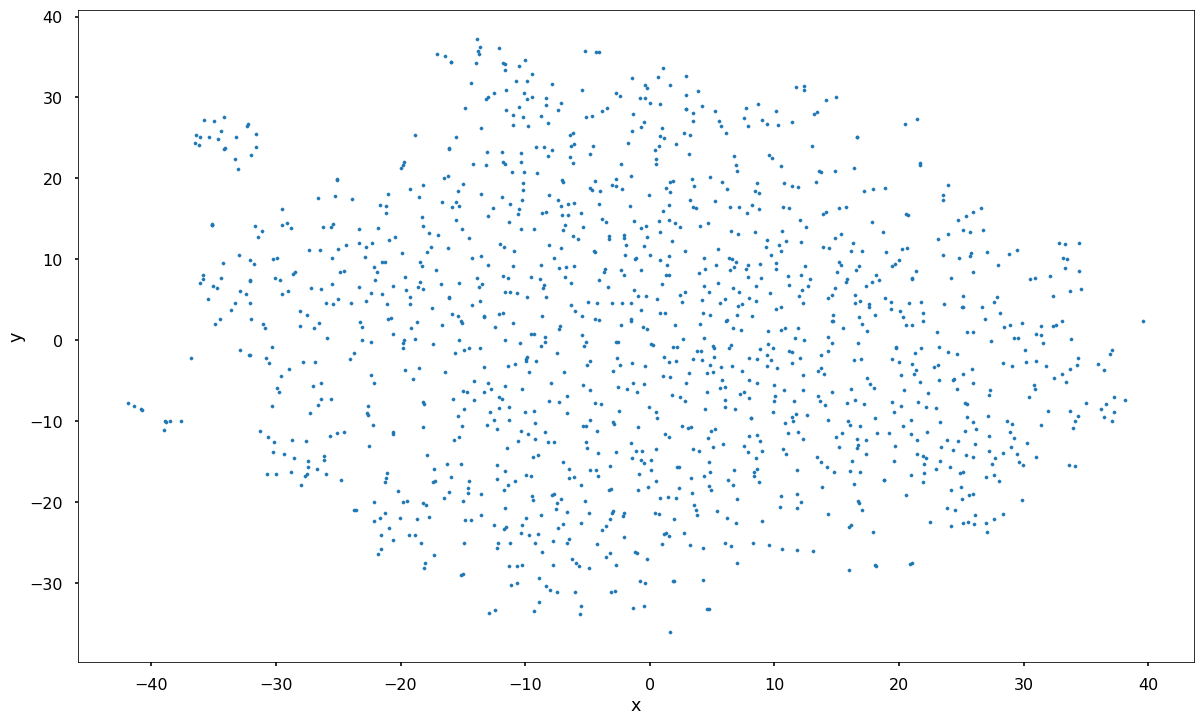

In [286]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [287]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

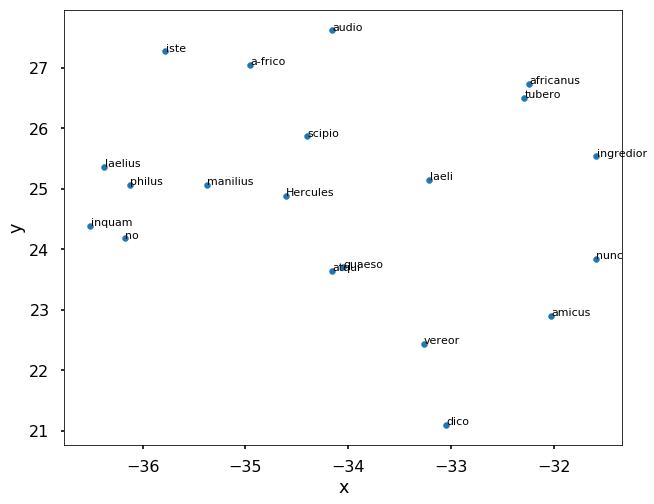

In [290]:
plot_region(x_bounds=(-40,-30), y_bounds=(20,30))
